In [126]:
import pandas
from scipy.stats import pearsonr, spearmanr
from scipy import mean, std, nanmean, nanstd
from math import log
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.mixture import GaussianMixture
from random import randint
from sklearn.linear_model import LinearRegression
from collections import Counter
from scipy.stats import wasserstein_distance
%matplotlib inline

In [2]:
downsamples = ['1', '5', '10', '25', 'full']

I used the data from the paper "Single-cell RNA-seq analysis of human pancreas from healthy individuals and type 2 diabetes patients (Segerstolpe 2016)".


> We used single-cell RNA-sequencing to generate transcriptional profiles of endocrine and exocrine cell types of the human pancreas. Pancreatic tissue and islets were obtained from six healthy and four T2D cadaveric donors. Islets were cultured and dissociated into single-cell suspension. Viable individual cells were distributed via fluorescence-activated cell sorted (FACS) into 384-well plates containing lysis buffer. Single-cell cDNA libraries were generated using the Smart-seq2 protocol. Gene expression was quantified as reads per kilobase transcript and per million mapped reads (RPKM) using rpkmforgenes. Bioinformatics analysis was used to classify cells into cell types without knowledge of cell types or prior purification of cell populations. We revealed subpopulations in endocrine and exocrine cell types, identified genes with interesting correlations to body mass index (BMI) in specific cell types and found transcriptional alterations in T2D.

I was able to download 2081 cell datasets. The data is 8.1 Gb. The datasets' properties:

* RNA-Seq single-end reads, length = 43 bp

* Summary of the cell types:

| cell type                   | count |
|-----------------------------|-----|
| acinar cell                 | 175 |
| alpha cell                  | 829 |
| beta cell                   | 249 |
| co-expression cell          | 38  |
| delta cell                  | 104 |
| ductal cell                 | 380 |
| endothelial cell            | 15  |
| epsilon cell                | 7   |
| gamma cell                  | 183 |
| mast cell                   | 7   |
| MHC class II cell           | 5   |
| PSC cell                    | 54  |
| unclassified cell           | 2   |
| unclassified endocrine cell | 33  |


# Read the datasets into the memory

In [3]:
kallisto = {}
for ds in downsamples:
    kallisto[ds] = pandas.read_csv("output_kallisto4/%s.tsv" % ds, index_col=0).applymap(lambda x: log(1.01 + x))

Because many genes are not expressed in several tissues at all, further, the correlations may be just "nan". In order to avoid numerical issues, I take only genes which are expressed (whose TPM > 100) in at least 1% of the cells

In [4]:
percentages = {}
for gene in kallisto["full"].index:
    geneExp = kallisto["full"].loc[gene]
    percentage = len([x for x in geneExp if x > log(100 + 1.01)])
    percentage /= float(len(geneExp))
    percentages[gene] = percentage

genes_sorted_by_percentages = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
good_genes = [x[0] for x in genes_sorted_by_percentages if x[1] > 0.01]

kallisto_good = {}
for ds in downsamples:
    kallisto_good[ds] = kallisto[ds].loc[good_genes]
    
kallisto = kallisto_good

# Perform KMeans analysis on all coordinates (full data)

In [5]:
NCLUSTERS = 6
kmeans = KMeans(n_clusters=NCLUSTERS).fit_predict(kallisto["full"].transpose())
cellnames = kallisto["full"].columns

# Rename the clusters in the full data

In [6]:
clust = sorted(Counter(kmeans).items(), key=lambda x: x[1], reverse=True)
transdict = {}
for i in range(NCLUSTERS):
    transdict[clust[i][0]] = i
newkmeans = []
for el in kmeans:
    newkmeans.append(transdict[el])
kmeans = newkmeans

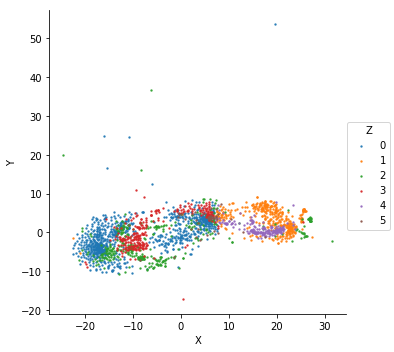

In [7]:
full_data = kallisto["1"].transpose()
# take only the top 1000 genes by their variance across the cells
variances = full_data.std(axis=0)
variances.sort_values(inplace=True, ascending=False)
index = variances.index[:1000]
# run PCA to reduce the dimensions to 50 - to speed up the tSNE
#full_data = pandas.DataFrame(PCA(n_components=50).fit_transform(full_data))
# run tSNE
tsne = TSNE(n_components=2, perplexity=50)
tsneComponents = tsne.fit_transform(full_data[index])
tsneCells = pandas.DataFrame({"X":tsneComponents[:,0], "Y":tsneComponents[:,1], "Z": kmeans})
sns.lmplot('X', 'Y', data=tsneCells, fit_reg=False, hue="Z", scatter_kws={"s": 2})

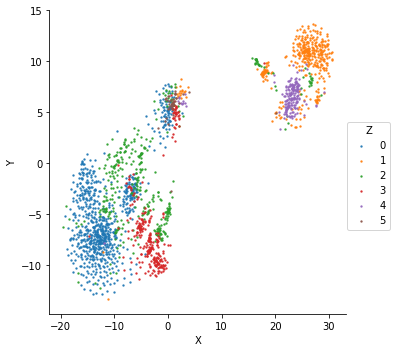

In [8]:
full_data = kallisto["5"].transpose()
# take only the top 1000 genes by their variance across the cells
variances = full_data.std(axis=0)
variances.sort_values(inplace=True, ascending=False)
index = variances.index[:1000]
# run PCA to reduce the dimensions to 50 - to speed up the tSNE
#full_data = pandas.DataFrame(PCA(n_components=50).fit_transform(full_data))
# run tSNE
tsne = TSNE(n_components=2, perplexity=50)
tsneComponents = tsne.fit_transform(full_data[index])
tsneCells = pandas.DataFrame({"X":tsneComponents[:,0], "Y":tsneComponents[:,1], "Z": kmeans})
sns.lmplot('X', 'Y', data=tsneCells, fit_reg=False, hue="Z", scatter_kws={"s": 2})

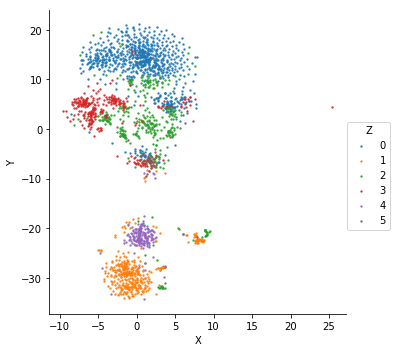

In [9]:
full_data = kallisto["10"].transpose()
# take only the top 1000 genes by their variance across the cells
variances = full_data.std(axis=0)
variances.sort_values(inplace=True, ascending=False)
index = variances.index[:1000]
# run PCA to reduce the dimensions to 50 - to speed up the tSNE
#full_data = pandas.DataFrame(PCA(n_components=50).fit_transform(full_data))
# run tSNE
tsne = TSNE(n_components=2, perplexity=50)
tsneComponents = tsne.fit_transform(full_data[index])
tsneCells = pandas.DataFrame({"X":tsneComponents[:,0], "Y":tsneComponents[:,1], "Z": kmeans})
sns.lmplot('X', 'Y', data=tsneCells, fit_reg=False, hue="Z", scatter_kws={"s": 2})

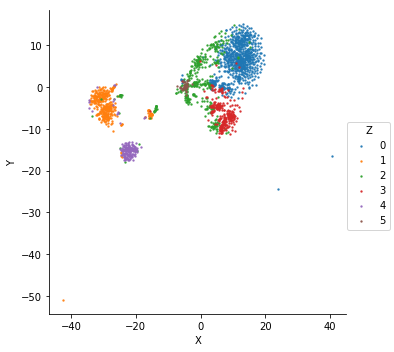

In [10]:
full_data = kallisto["25"].transpose()
# take only the top 1000 genes by their variance across the cells
variances = full_data.std(axis=0)
variances.sort_values(inplace=True, ascending=False)
index = variances.index[:1000]
# run PCA to reduce the dimensions to 50 - to speed up the tSNE
#full_data = pandas.DataFrame(PCA(n_components=50).fit_transform(full_data))
# run tSNE
tsne = TSNE(n_components=2, perplexity=50)
tsneComponents = tsne.fit_transform(full_data[index])
tsneCells = pandas.DataFrame({"X":tsneComponents[:,0], "Y":tsneComponents[:,1], "Z": kmeans})
sns.lmplot('X', 'Y', data=tsneCells, fit_reg=False, hue="Z", scatter_kws={"s": 2})

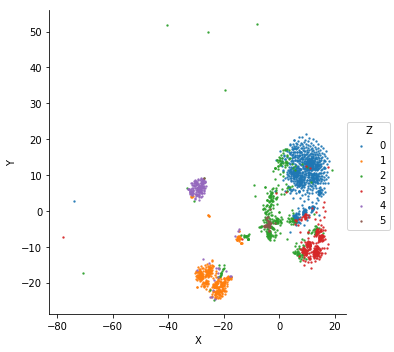

In [11]:
full_data = kallisto["full"].transpose()
# take only the top 1000 genes by their variance across the cells
variances = full_data.std(axis=0)
variances.sort_values(inplace=True, ascending=False)
index = variances.index[:1000]
# run PCA to reduce the dimensions to 50 - to speed up the tSNE
#full_data = pandas.DataFrame(PCA(n_components=50).fit_transform(full_data))
# run tSNE
tsne = TSNE(n_components=2, perplexity=50)
tsneComponents = tsne.fit_transform(full_data[index])
tsneCells = pandas.DataFrame({"X":tsneComponents[:,0], "Y":tsneComponents[:,1], "Z": kmeans})
sns.lmplot('X', 'Y', data=tsneCells, fit_reg=False, hue="Z", scatter_kws={"s": 2})

In [68]:
cell_type_dict = {}
type_cell_dict = {}

for ctype, cell in zip(kmeans, cellnames):
    cell_type_dict[cell] = ctype
    if ctype not in type_cell_dict:
        type_cell_dict[ctype] = []
    type_cell_dict[ctype].append(cell)

In [69]:
type_cell_dict.keys()

[0, 1, 2, 3, 4, 5]

In [70]:
type_cell_df = {}

for ctype in type_cell_dict:
    ct = {}
    for ds in downsamples:
        ct[ds] = kallisto[ds][type_cell_dict[ctype]]
    type_cell_df[ctype] = ct

In [71]:
type_cell_mean = {}

for ctype in type_cell_dict:
    ct = {}
    for ds in downsamples:
        ct[ds] = type_cell_df[ctype][ds].mean(axis=1)
    type_cell_mean[ctype] = ct


# Check how many genes are detected in each of the cell types across all the cells

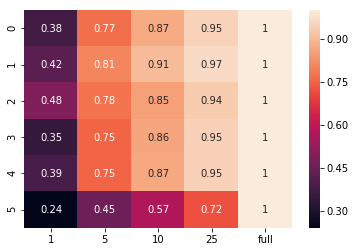

In [16]:
type_cell_missing = {}


for ds in downsamples:
    corrs = []
    for ctype in type_cell_dict:
        detected = 0
        allofthem = 0
        for x, y in zip(type_cell_mean[ctype][ds], type_cell_mean[ctype]["full"]):
            if y > 1:
                allofthem += 1
                if x > 1:
                    detected += 1
        corrs.append(detected * 1.0 / allofthem)
        type_cell_missing[ds] = corrs
    
    
type_cell_missing = pandas.DataFrame(type_cell_missing)
ctype_index2 = {}
for i, ctype in enumerate(type_cell_dict):
    ctype_index2[i] = ctype
type_cell_missing = type_cell_missing.rename(ctype_index2, axis='index')
type_cell_missing = type_cell_missing[downsamples]
heatmap0 = sns.heatmap(type_cell_missing, annot=True)

# Spearman correlation between mean gene expression for each downsample and full dataset (for each coverage)

#### Here are the results for all the genes

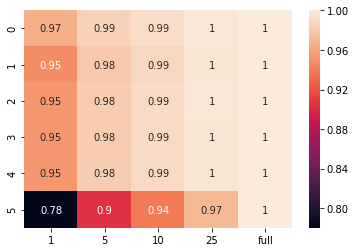

In [17]:
spearmans = {}

for ds in downsamples:
    corrs = []
    for ctype in type_cell_dict:
        corrs.append(spearmanr(type_cell_mean[ctype][ds], type_cell_mean[ctype]["full"])[0])
    spearmans[ds] = corrs
spearmans = pandas.DataFrame(spearmans)
ctype_index = {}
for i, ctype in enumerate(type_cell_dict):
    ctype_index[i] = ctype
spearmans = spearmans.rename(ctype_index, axis='index')
spearmans = spearmans[downsamples]
heatmap1 = sns.heatmap(spearmans, annot=True)

#### Here are the results for genes with TPM < 10

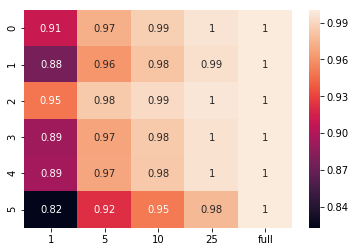

In [18]:
spearmans2 = {}

kallisto_mean = kallisto["full"].mean(axis=1)

indx = kallisto_mean[kallisto_mean <= 5].index

for ds in downsamples:
    corrs = []
    for ctype in type_cell_dict:
        corrs.append(pearsonr(type_cell_mean[ctype][ds].loc[indx], type_cell_mean[ctype]["full"].loc[indx])[0])
    spearmans2[ds] = corrs
spearmans2 = pandas.DataFrame(spearmans2)
ctype_index = {}
for i, ctype in enumerate(type_cell_dict):
    ctype_index[i] = ctype
spearmans2 = spearmans2.rename(ctype_index, axis='index')
spearmans2 = spearmans2[downsamples]

heatmap2 = sns.heatmap(spearmans2, annot=True)

#### Here are the results for genes with 10 <= TPM <= 100

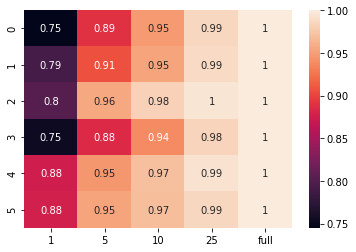

In [19]:
spearmans3 = {}

kallisto_mean = kallisto["full"].mean(axis=1)
indx = kallisto_mean[(kallisto_mean >= 5) & (kallisto_mean <= 7)].index



for ds in downsamples:
    corrs = []
    for ctype in type_cell_dict:
        corrs.append(spearmanr(type_cell_mean[ctype][ds].loc[indx], type_cell_mean[ctype]["full"].loc[indx])[0])
    spearmans3[ds] = corrs
spearmans3 = pandas.DataFrame(spearmans3)
ctype_index = {}
for i, ctype in enumerate(type_cell_dict):
    ctype_index[i] = ctype
spearmans3 = spearmans3.rename(ctype_index, axis='index')
spearmans3 = spearmans3[downsamples]


heatmap3 = sns.heatmap(spearmans3, annot=True)

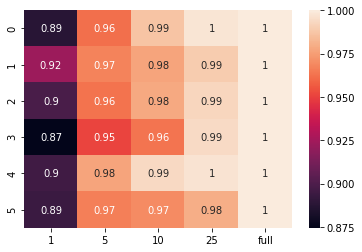

In [20]:
spearmans4 = {}

kallisto_mean = kallisto["full"].mean(axis=1)
indx = kallisto_mean[(kallisto_mean >= 7)].index

for ds in downsamples:
    corrs = []
    for ctype in type_cell_dict:
        corrs.append(spearmanr(type_cell_mean[ctype][ds].loc[indx], type_cell_mean[ctype]["full"].loc[indx])[0])
    spearmans4[ds] = corrs
spearmans4 = pandas.DataFrame(spearmans4)
ctype_index = {}
for i, ctype in enumerate(type_cell_dict):
    ctype_index[i] = ctype
spearmans4 = spearmans4.rename(ctype_index, axis='index')
spearmans4 = spearmans4[downsamples]

heatmap4 = sns.heatmap(spearmans4, annot=True)

# For 1% downsample, cell types having more cells have higher correlation with the full dataset.

In [21]:
cell_counts = dict(map(lambda x: (x[0], len(x[1])), type_cell_dict.items()))

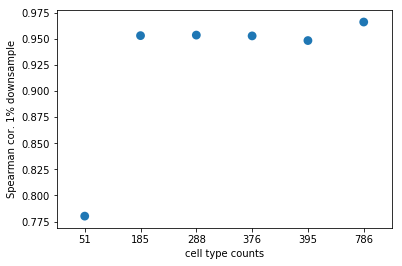

In [22]:
correlations_1 = dict(spearmans["1"])

cell_counts.values()
a = sns.pointplot(cell_counts.values(), correlations_1.values(), join=False, errwidth=0)
a.set(xlabel='cell type counts', ylabel='Spearman cor. 1% downsample')
plt.show()

# Check the results on a random clustering

In [33]:
random_cell_types = {}
for v in cellnames:
    u = randint(0, NCLUSTERS)
    if u not in random_cell_types:
        random_cell_types[u] = []
    random_cell_types[u].append(v)

In [34]:
type_cell_df_random = {}

for ctype in random_tsne_cell_types:
    ct = {}
    for ds in downsamples:
        ct[ds] = kallisto[ds][random_tsne_cell_types[ctype]]
    type_cell_df_random[ctype] = ct

In [35]:
type_cell_mean_random = {}

for ctype in random_tsne_cell_types:
    ct = {}
    for ds in downsamples:
        ct[ds] = type_cell_df_random[ctype][ds].mean(axis=1)
    type_cell_mean_random[ctype] = ct

In [36]:
spearmans_random = {}

for ds in downsamples:
    corrs = []
    for ctype in random_tsne_cell_types:
        corrs.append(spearmanr(type_cell_mean_random[ctype][ds], type_cell_mean_random[ctype]["full"])[0])
    spearmans_random[ds] = corrs
spearmans_random = pandas.DataFrame(spearmans_random)
ctype_index_random = {}
for i, ctype in enumerate(random_tsne_cell_types):
    ctype_index_random[i] = ctype
spearmans_random = spearmans_random.rename(ctype_index_random, axis='index')
spearmans_random = spearmans_random[downsamples]

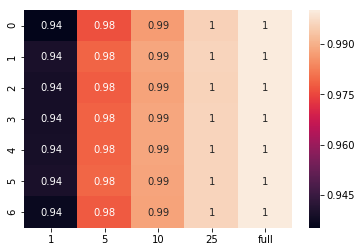

In [37]:
heatmap1_random = sns.heatmap(spearmans_random, annot=True)

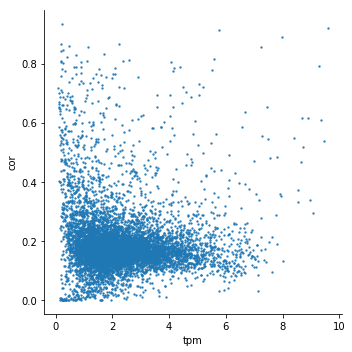

In [39]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    correlations.append(pearsonr(kallisto["1"].iloc[i], kallisto["full"].iloc[i])[0] * pearsonr(kallisto["1"].iloc[i], kallisto["full"].iloc[i])[0])
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "cor": correlations})
sns.lmplot("tpm", "cor", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

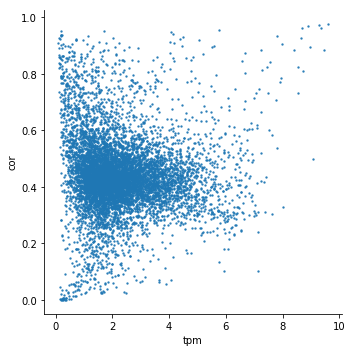

In [40]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    correlations.append(pearsonr(kallisto["5"].iloc[i], kallisto["full"].iloc[i])[0] * pearsonr(kallisto["5"].iloc[i], kallisto["full"].iloc[i])[0])
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "cor": correlations})
sns.lmplot("tpm", "cor", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

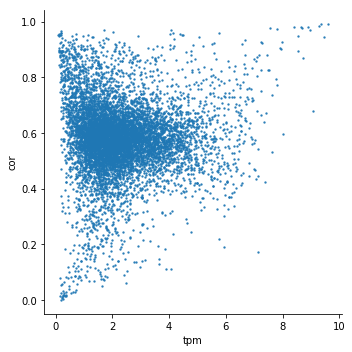

In [41]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    correlations.append(pearsonr(kallisto["10"].iloc[i], kallisto["full"].iloc[i])[0] * pearsonr(kallisto["10"].iloc[i], kallisto["full"].iloc[i])[0])
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "cor": correlations})
sns.lmplot("tpm", "cor", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

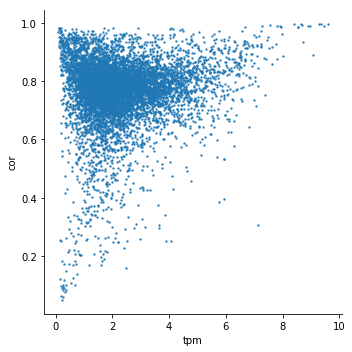

In [42]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    correlations.append(pearsonr(kallisto["25"].iloc[i], kallisto["full"].iloc[i])[0] * pearsonr(kallisto["25"].iloc[i], kallisto["full"].iloc[i])[0])
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "cor": correlations})
sns.lmplot("tpm", "cor", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

In this section, I bin the genes by their TPM in the full dataset. Then for each bin, for each gene in the bin, I compute the $R^2$ between the gene expression across all the cells for a downsample and the full dataset. In each plot presented below, $x$ axis is TPM * 100 (bins) and $y$ axis is mean $R^2$ in that bin.

In [61]:
slicing = 35

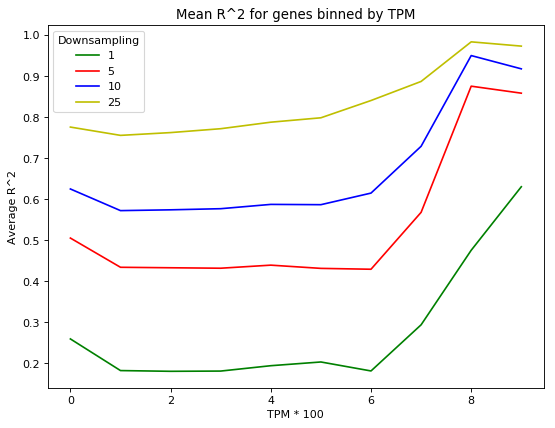

In [62]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
    
full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto[ds].loc[gene], kallisto["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))

figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Same thing - cell type 0

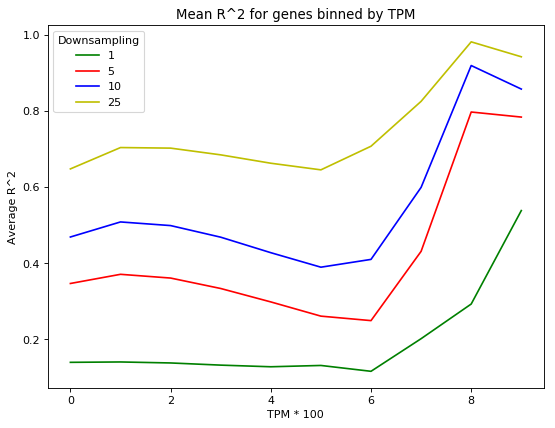

In [50]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][type_cell_dict[0]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Same thing - cell type 1

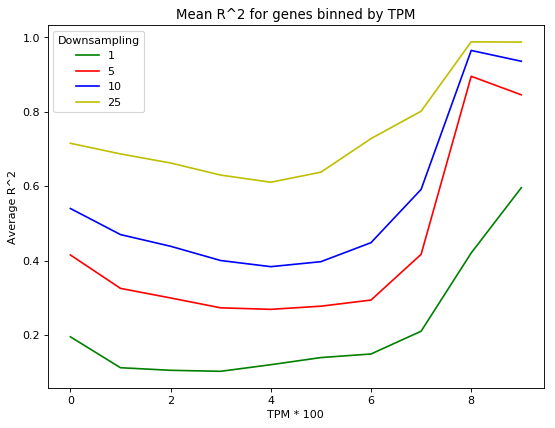

In [51]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][type_cell_dict[1]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Same thing - cell type 2

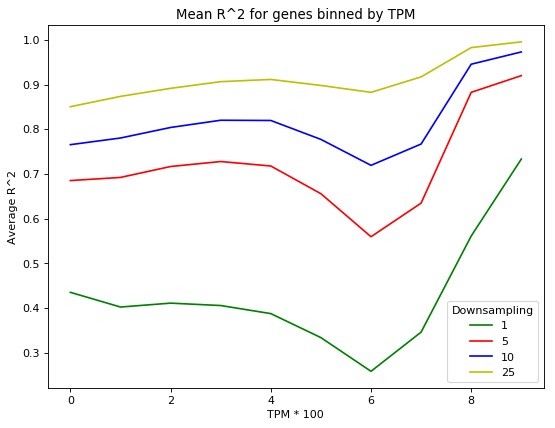

In [52]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][type_cell_dict[2]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Same thing - cell type 3

/home/igorm/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


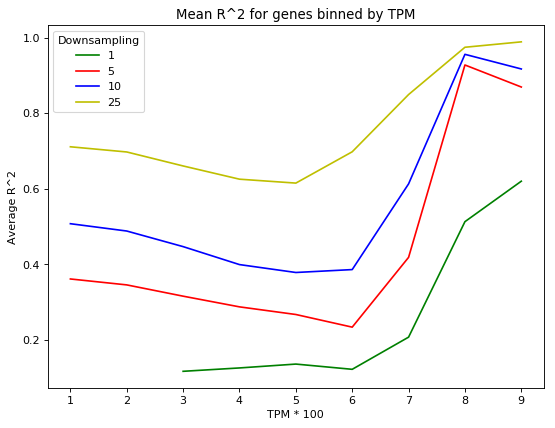

In [53]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][type_cell_dict[3]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Same thing - cell type 4

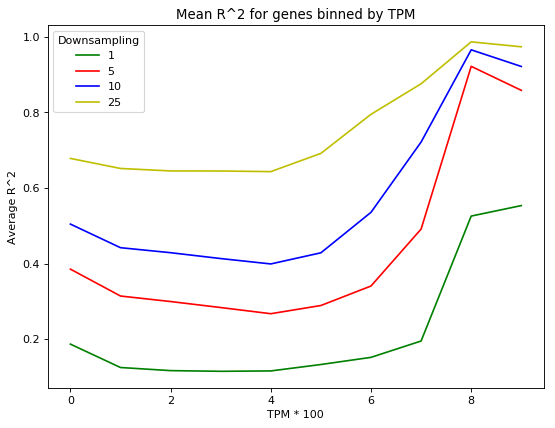

In [54]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][type_cell_dict[4]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Same thing - cell type 5

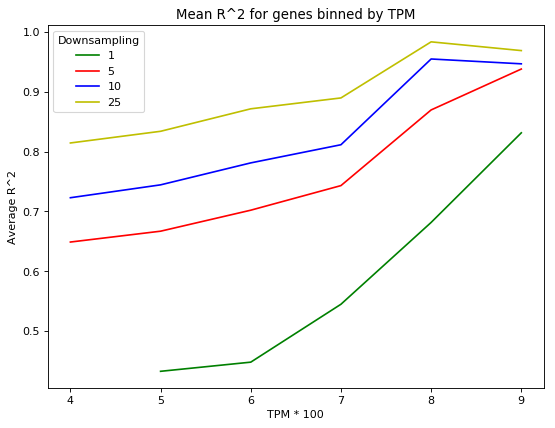

In [55]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][type_cell_dict[5]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Compute $R^2$ between cell type means (6-dimensional vectors) for each gene, bin genes by TPMs

In this section, I did the following. For each gene, I computed its average TPM across the cell types, thus, obtaining a 6-dimensional vector $p$. For each gene, I computed $R^2$ between $p_{downsample}$ and $p_{full}$. I grouped the $R^2$ by the TPM of the corresponding gene. In the plot below, $x$ axis is TPM * 100 (TPM bins), and the $y$ axis is the average $R^2$ in the bin.

(0, 1)

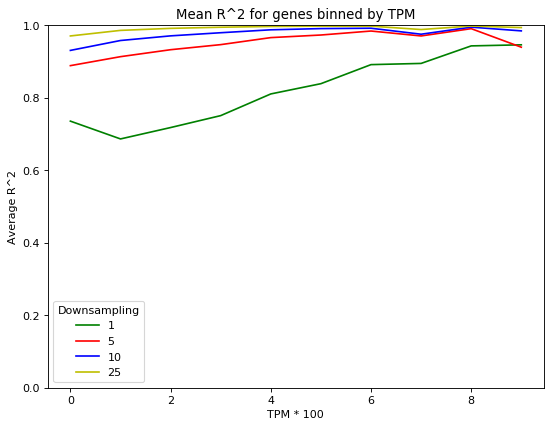

In [75]:
ctdf = {}
for ds in downsamples:
    ctdf[ds] = pandas.DataFrame({"0": kallisto[ds][type_cell_dict[0]].mean(axis=1),
                         "1": kallisto[ds][type_cell_dict[1]].mean(axis=1),
                         "2": kallisto[ds][type_cell_dict[2]].mean(axis=1),
                         "3": kallisto[ds][type_cell_dict[3]].mean(axis=1),
                         "4": kallisto[ds][type_cell_dict[4]].mean(axis=1),
                         "5": kallisto[ds][type_cell_dict[5]].mean(axis=1)
                        })
    
r2s = {}
for ds in downsamples:
    r2s[ds] = {}
    
genes = ctdf["full"].index
for gene in genes:
    for ds in downsamples:
        r2 = pearsonr(ctdf[ds].loc[gene], ctdf["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in r2s[ds]:
            r2s[ds][bin_for_gene] = []
        r2s[ds][bin_for_gene].append(r2)

    
r2s_mean = {}
xs = sorted(r2s["1"].keys())

for ds in downsamples:
    r2s_mean[ds] = []
    for i in range(max(r2s[ds].keys()) + 1):
        if i in r2s[ds]:
            r2s_mean[ds].append(mean(r2s[ds][i]))
            
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], r2s_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], r2s_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], r2s_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], r2s_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')
axes = plt.gca()
axes.set_ylim([0, 1])

(0, 1)

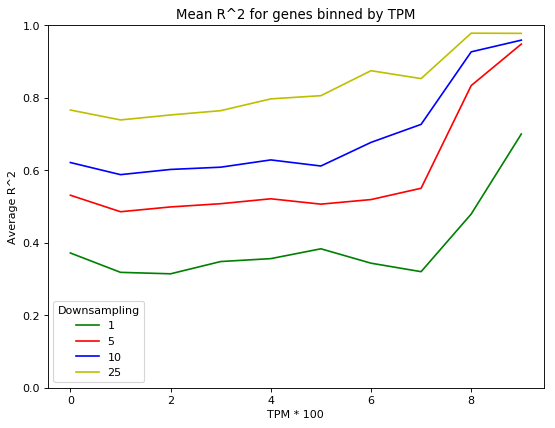

In [76]:

cell_type_dict_random = {}

for ct in type_cell_dict:
    cell_type_dict_random[ct] = []

for x, y in zip(kallisto["full"].columns, kmeans):
    cell_type_dict_random[randint(0, 5)].append(x)

ctdf = {}
for ds in downsamples:
    ctdf[ds] = pandas.DataFrame({"0": kallisto[ds][cell_type_dict_random[0]].mean(axis=1),
                         "1": kallisto[ds][cell_type_dict_random[1]].mean(axis=1),
                         "2": kallisto[ds][cell_type_dict_random[2]].mean(axis=1),
                         "3": kallisto[ds][cell_type_dict_random[3]].mean(axis=1),
                         "4": kallisto[ds][cell_type_dict_random[4]].mean(axis=1),
                         "5": kallisto[ds][cell_type_dict_random[5]].mean(axis=1)
                        })
    
r2s = {}
for ds in downsamples:
    r2s[ds] = {}
    
genes = ctdf["full"].index
for gene in genes:
    for ds in downsamples:
        r2 = pearsonr(ctdf[ds].loc[gene], ctdf["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in r2s[ds]:
            r2s[ds][bin_for_gene] = []
        r2s[ds][bin_for_gene].append(r2)

    
r2s_mean = {}
xs = sorted(r2s["1"].keys())

for ds in downsamples:
    r2s_mean[ds] = []
    for i in range(max(r2s[ds].keys()) + 1):
        if i in r2s[ds]:
            r2s_mean[ds].append(mean(r2s[ds][i]))
            
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], r2s_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], r2s_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], r2s_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], r2s_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')
axes = plt.gca()
axes.set_ylim([0, 1])

# Correlations across individuals

In this section, I group the cells by individuals and by cell types. Namely, inside of each cell type, I group the cells by individuals and for each gene, I compute the mean expression over the group of cells. As a results, for each gene, I have vectors with 10 coordinates corresponding to the 10 individuals. For each gene, I compute pearson correlation between 10-vectors of the full datasets and 10-vectors of downsampled datasets.

In [59]:
with open("PATIENTS") as f:
    patients = f.readlines()
patients = map(lambda x: x.strip().split(","), patients)
pdict = {}
for x, y in patients:
    if y not in pdict:
        pdict[y] = []
    pdict[y].append(x)
    
ctdict = {}
for x, y in cell_type_dict.items():
    for z in y:
        ctdict[z] = x
    

pcdict = {}
for x in pdict.keys():
    pcdict[x] = {}
    for cell in pdict[x]:
        ct = ctdict[cell]
        if ct not in pcdict[x]:
            pcdict[x][ct] = []
        pcdict[x][ct].append(cell)

In [79]:
cellTypeAverages = {} # key: cell type, value: dataframe of gene averages across individuals
for cell_type in type_cell_dict:
    downs = {}
    for ds in downsamples:
        df = {}
        for individual in pcdict.keys():
            #print pcdict[individual].keys()
            if cell_type in pcdict[individual]:
                cells = pcdict[individual][cell_type]
                cells_df = kallisto[ds][cells]
                df[individual] = cells_df.mean(axis=1)
        df = pandas.DataFrame(df)
        downs[ds] = df
    cellTypeAverages[cell_type] = downs

In [81]:
avgTpm = kallisto["full"].mean(axis = 1)

# Cell type 0

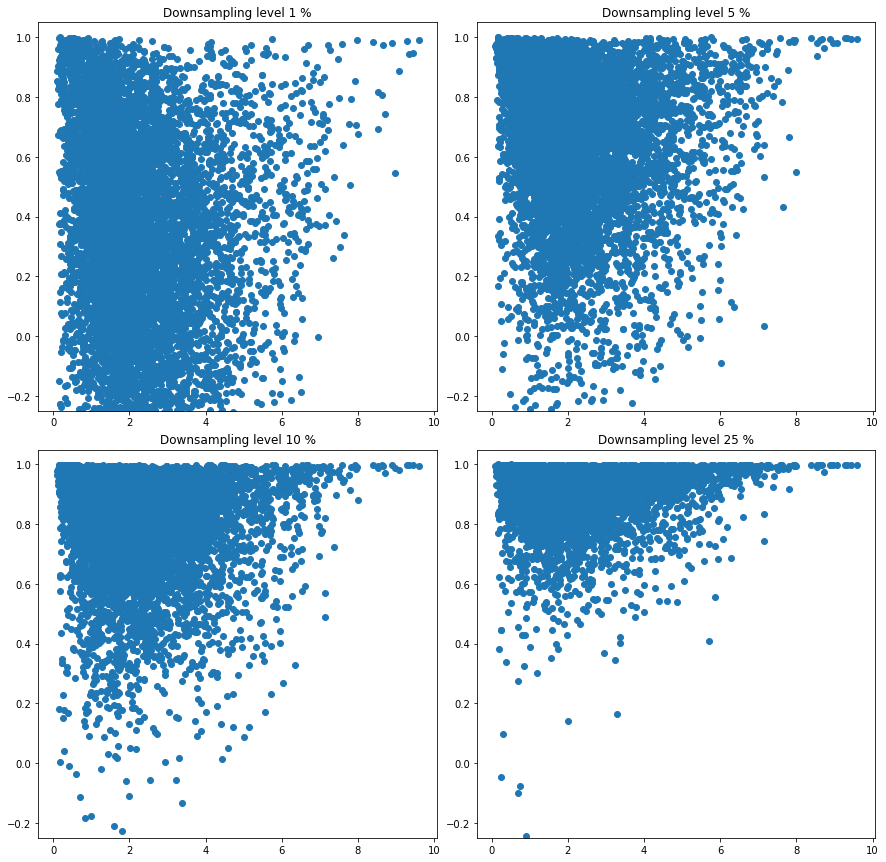

In [82]:
ct = 0
cellTypeSpecific1 = {}
for ds in downsamples:
    cellTypeSpecific1[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific1[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific1[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


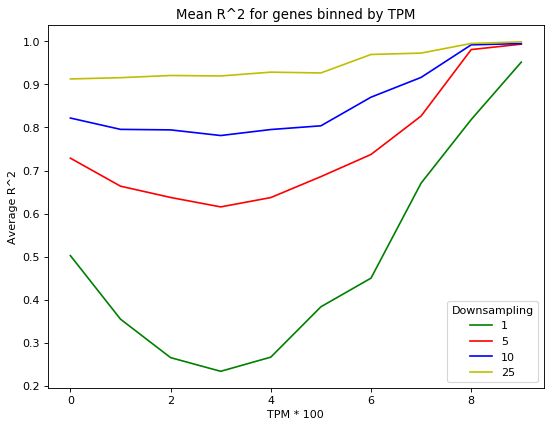

In [83]:


corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific1[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean1 = {}
for ds in downsamples:
    corr_dict_mean1[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean1[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean1["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean1["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean1["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean1["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')



# Cell type 1

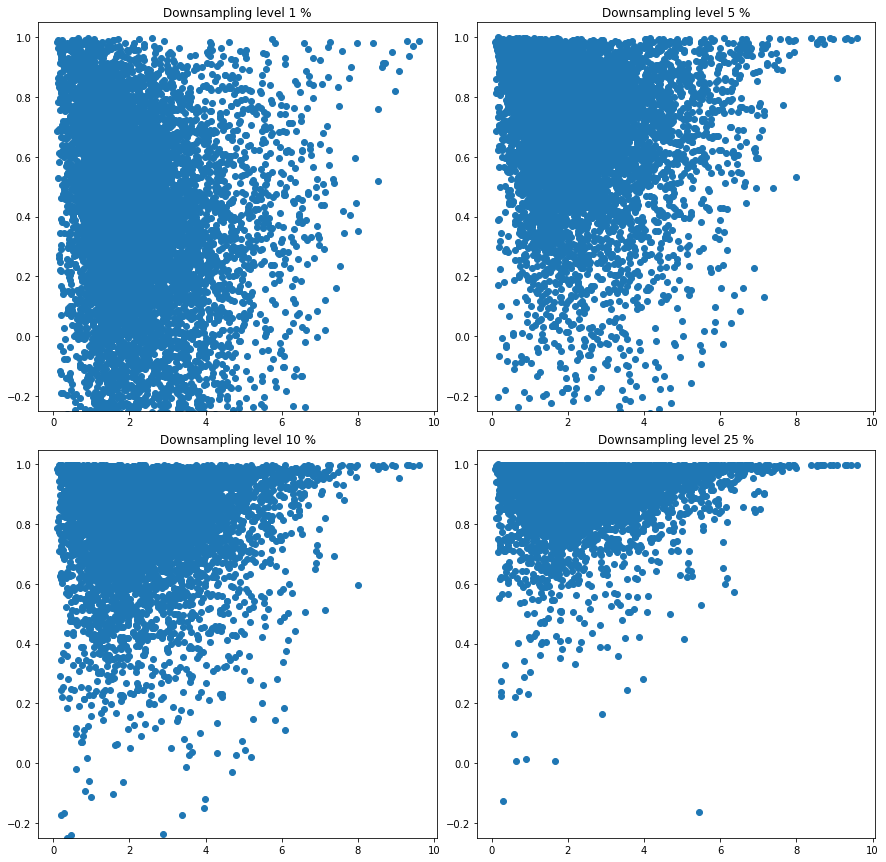

In [84]:
ct = 1
cellTypeSpecific2 = {}
for ds in downsamples:
    cellTypeSpecific2[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific2[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific2[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


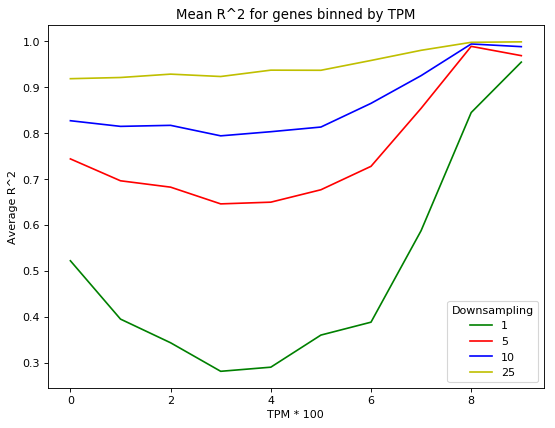

In [85]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific2[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean2 = {}
for ds in downsamples:
    corr_dict_mean2[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean2[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean2["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean2["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean2["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean2["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 2

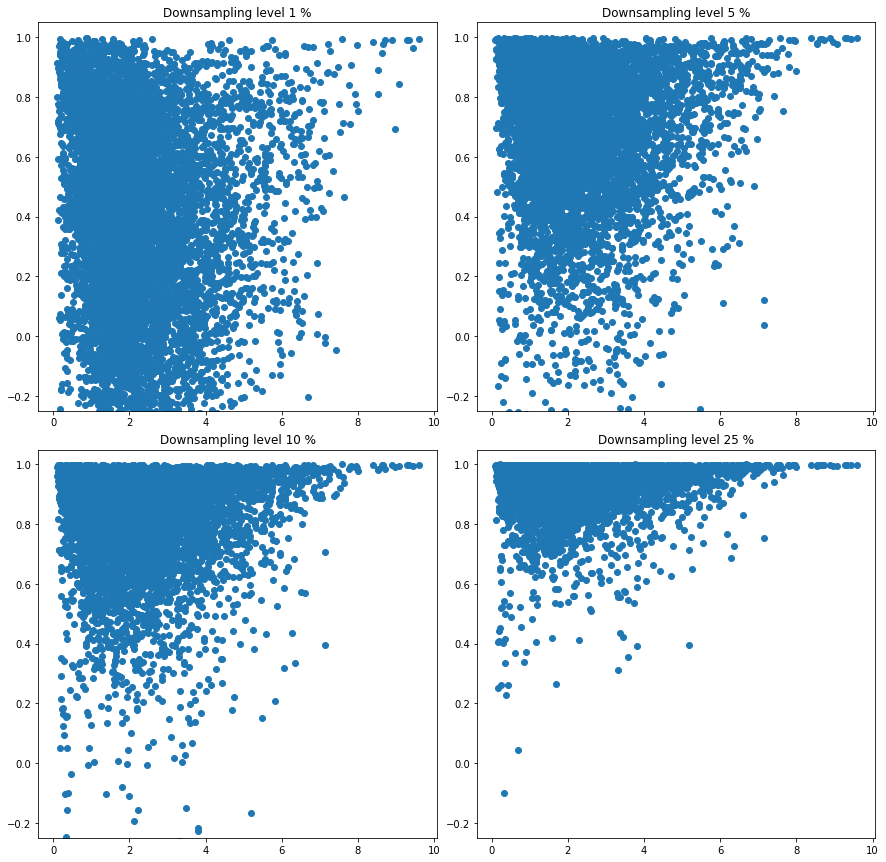

In [86]:
ct = 2
cellTypeSpecific3 = {}
for ds in downsamples:
    cellTypeSpecific3[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific3[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific3[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


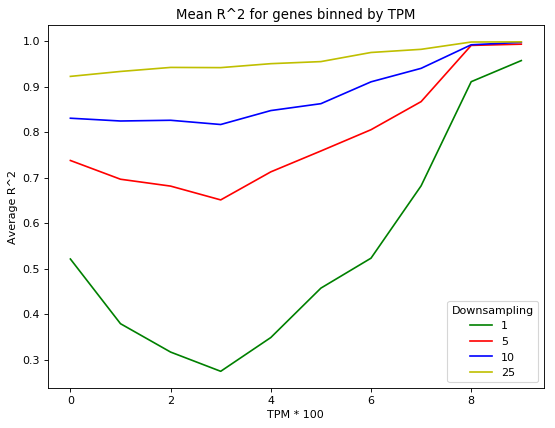

In [87]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific3[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean3 = {}
for ds in downsamples:
    corr_dict_mean3[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean3[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean3["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean3["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean3["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean3["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 3

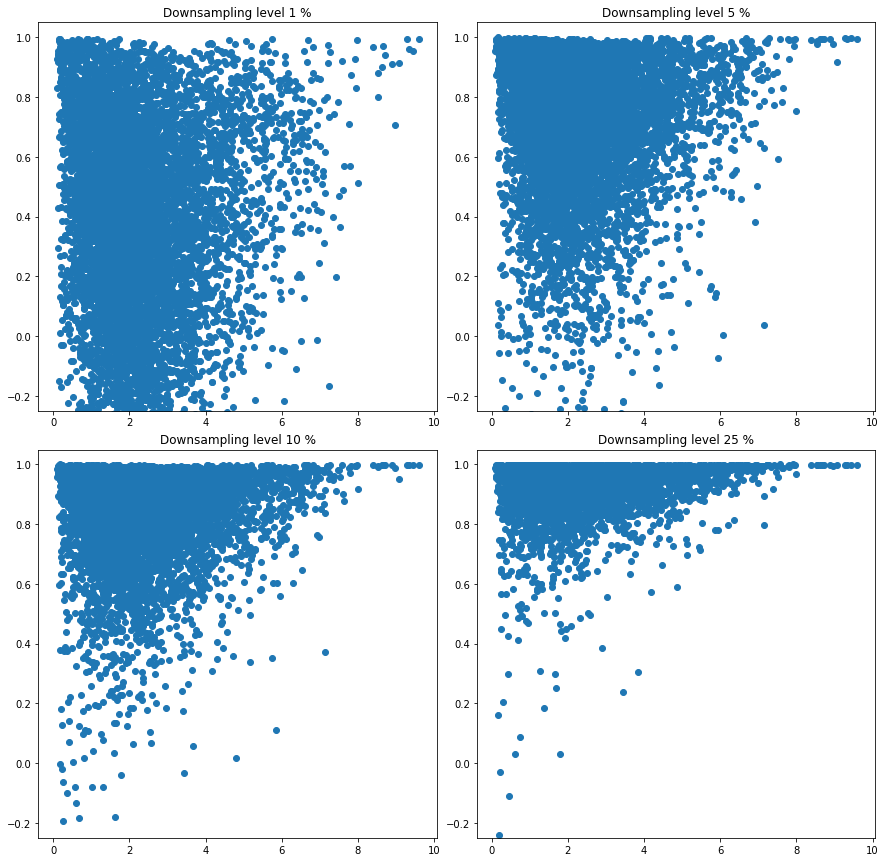

In [88]:
ct = 3
cellTypeSpecific4 = {}
for ds in downsamples:
    cellTypeSpecific4[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific4[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific4[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


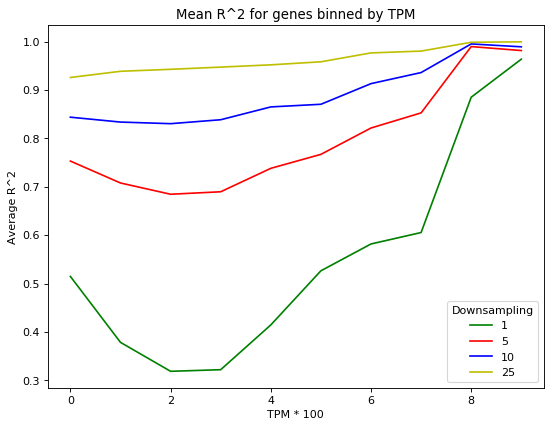

In [89]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific4[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean4 = {}
for ds in downsamples:
    corr_dict_mean4[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean4[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean4["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean4["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean4["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean4["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 4

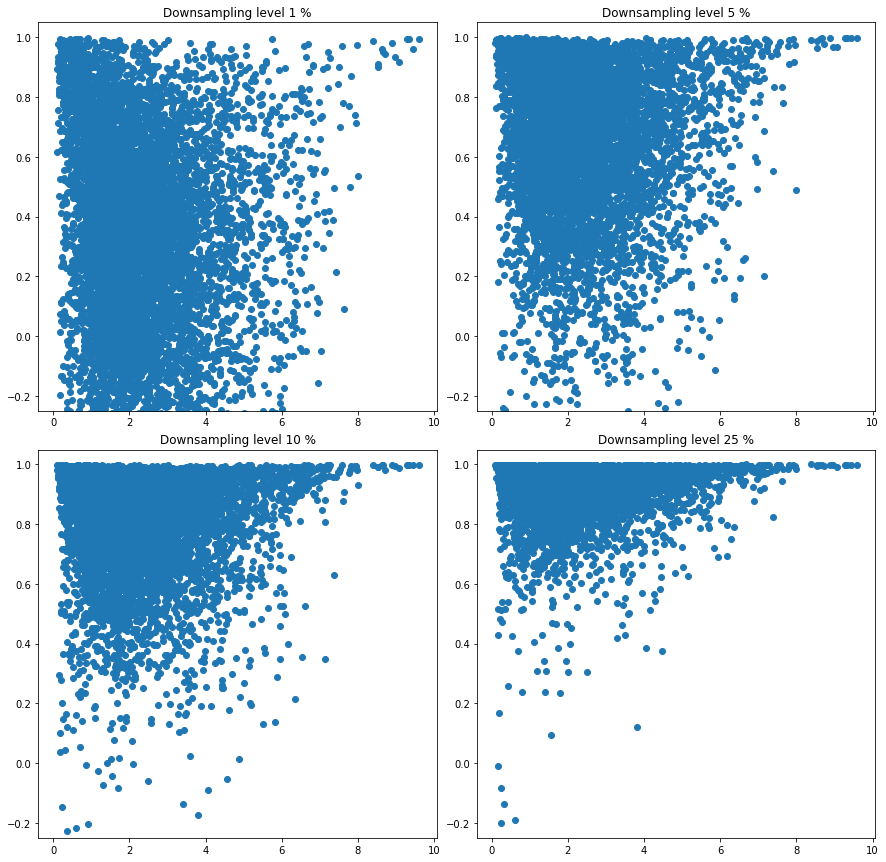

In [90]:
ct = 4
cellTypeSpecific5 = {}
for ds in downsamples:
    cellTypeSpecific5[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific5[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific5[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


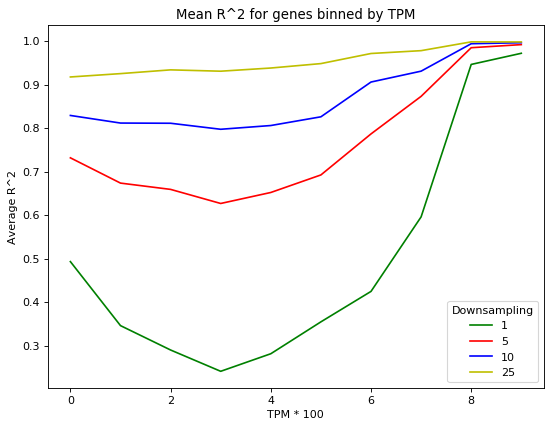

In [91]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific5[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean5 = {}
for ds in downsamples:
    corr_dict_mean5[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean5[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean5["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean5["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean5["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean5["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 5

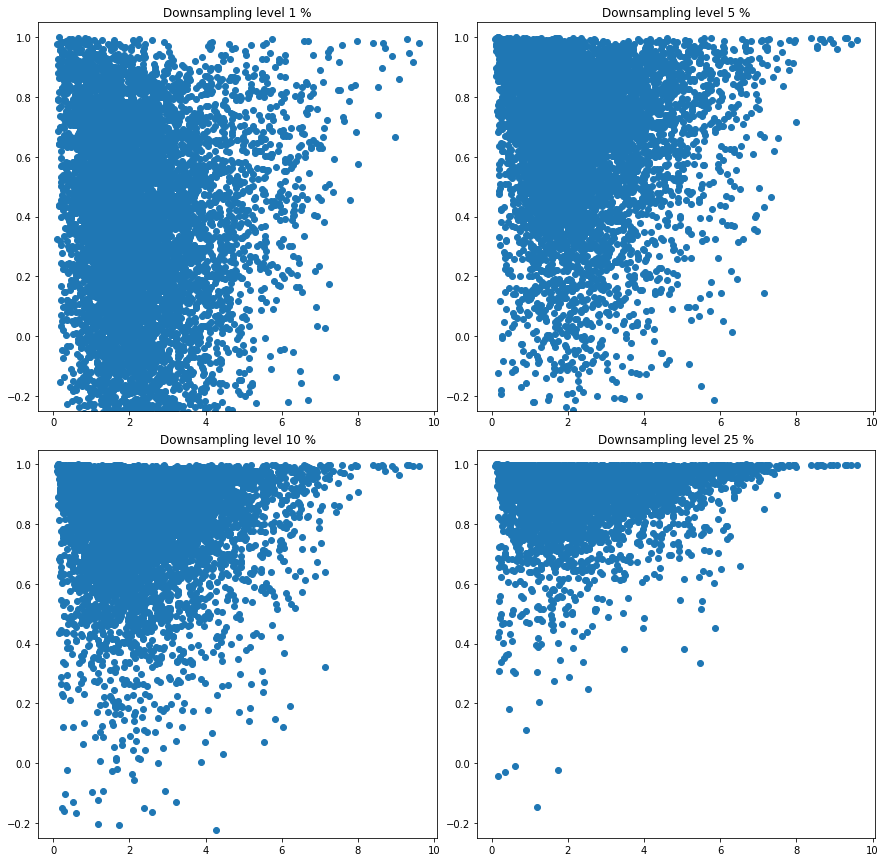

In [93]:
ct = 5
cellTypeSpecific6 = {}
for ds in downsamples:
    cellTypeSpecific6[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific6[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific6[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


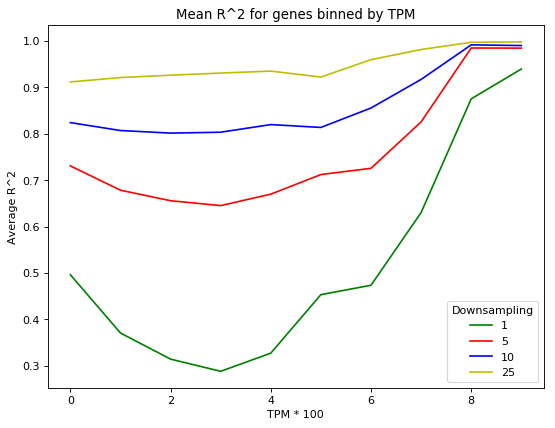

In [94]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific6[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean6 = {}
for ds in downsamples:
    corr_dict_mean6[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean6[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean6["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean6["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean6["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean6["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Mean pearson correlation for each cell type across different subsampling levels

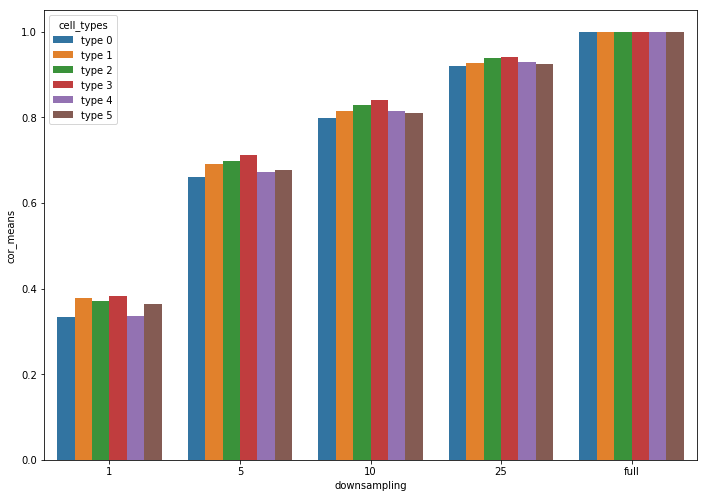

In [99]:
ct1means = [nanmean(cellTypeSpecific1["1"]), 
            nanmean(cellTypeSpecific1["5"]), 
            nanmean(cellTypeSpecific1["10"]), 
            nanmean(cellTypeSpecific1["25"]), 
            nanmean(cellTypeSpecific1["full"])]

ct2means = [nanmean(cellTypeSpecific2["1"]), 
            nanmean(cellTypeSpecific2["5"]), 
            nanmean(cellTypeSpecific2["10"]), 
            nanmean(cellTypeSpecific2["25"]), 
            nanmean(cellTypeSpecific2["full"])]

ct3means = [nanmean(cellTypeSpecific3["1"]), 
            nanmean(cellTypeSpecific3["5"]), 
            nanmean(cellTypeSpecific3["10"]), 
            nanmean(cellTypeSpecific3["25"]), 
            nanmean(cellTypeSpecific3["full"])]

ct4means = [nanmean(cellTypeSpecific4["1"]), 
            nanmean(cellTypeSpecific4["5"]), 
            nanmean(cellTypeSpecific4["10"]), 
            nanmean(cellTypeSpecific4["25"]), 
            nanmean(cellTypeSpecific4["full"])]

ct5means = [nanmean(cellTypeSpecific5["1"]), 
            nanmean(cellTypeSpecific5["5"]), 
            nanmean(cellTypeSpecific5["10"]), 
            nanmean(cellTypeSpecific5["25"]), 
            nanmean(cellTypeSpecific5["full"])]

ct6means = [nanmean(cellTypeSpecific6["1"]), 
            nanmean(cellTypeSpecific6["5"]), 
            nanmean(cellTypeSpecific6["10"]), 
            nanmean(cellTypeSpecific6["25"]), 
            nanmean(cellTypeSpecific6["full"])]

ctmeans = ct1means + ct2means + ct3means + ct4means + ct5means + ct6means
cttypes = 5 * ["type 0"] + 5 * ["type 1"] + 5 * ["type 2"] + 5 * ["type 3"] + 5 * ["type 4"] + 5 * ["type 5"]
ctdowns = 6 * ["1", "5", "10", "25", "full"]
ctbars = pandas.DataFrame({"cor_means": ctmeans, "cell_types": cttypes, "downsampling": ctdowns})

a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(x="downsampling", y="cor_means", hue="cell_types", data=ctbars)

# Std of  pearson correlation for each cell type across different subsampling levels

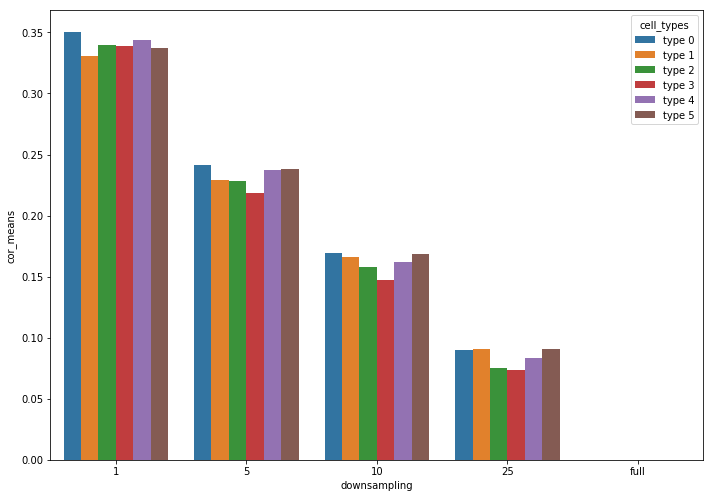

In [127]:
ct1means = [nanstd(cellTypeSpecific1["1"]), 
            nanstd(cellTypeSpecific1["5"]), 
            nanstd(cellTypeSpecific1["10"]), 
            nanstd(cellTypeSpecific1["25"]), 
            nanstd(cellTypeSpecific1["full"])]

ct2means = [nanstd(cellTypeSpecific2["1"]), 
            nanstd(cellTypeSpecific2["5"]), 
            nanstd(cellTypeSpecific2["10"]), 
            nanstd(cellTypeSpecific2["25"]), 
            nanstd(cellTypeSpecific2["full"])]

ct3means = [nanstd(cellTypeSpecific3["1"]), 
            nanstd(cellTypeSpecific3["5"]), 
            nanstd(cellTypeSpecific3["10"]), 
            nanstd(cellTypeSpecific3["25"]), 
            nanstd(cellTypeSpecific3["full"])]

ct4means = [nanstd(cellTypeSpecific4["1"]), 
            nanstd(cellTypeSpecific4["5"]), 
            nanstd(cellTypeSpecific4["10"]), 
            nanstd(cellTypeSpecific4["25"]), 
            nanstd(cellTypeSpecific4["full"])]

ct5means = [nanstd(cellTypeSpecific5["1"]), 
            nanstd(cellTypeSpecific5["5"]), 
            nanstd(cellTypeSpecific5["10"]), 
            nanstd(cellTypeSpecific5["25"]), 
            nanstd(cellTypeSpecific5["full"])]

ct6means = [nanstd(cellTypeSpecific6["1"]), 
            nanstd(cellTypeSpecific6["5"]), 
            nanstd(cellTypeSpecific6["10"]), 
            nanstd(cellTypeSpecific6["25"]), 
            nanstd(cellTypeSpecific6["full"])]

ctmeans = ct1means + ct2means + ct3means + ct4means + ct5means + ct6means
cttypes = 5 * ["type 0"] + 5 * ["type 1"] + 5 * ["type 2"] + 5 * ["type 3"] + 5 * ["type 4"] + 5 * ["type 5"]
ctdowns = 6 * ["1", "5", "10", "25", "full"]
ctbars = pandas.DataFrame({"cor_means": ctmeans, "cell_types": cttypes, "downsampling": ctdowns})

a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(x="downsampling", y="cor_means", hue="cell_types", data=ctbars)

# Computing EMD distances between gene distributions for a patient

In [103]:
d1 = []
for i in range(8201):
    mmm = [x for x in kallisto["1"][pdict["HP1502401"]].iloc[i] if x > 0.1]
    if mmm == []:
        mmm = kallisto["1"][pdict["HP1502401"]].iloc[i]
    d1.append(wasserstein_distance(mmm, kallisto["full"][pdict["HP1502401"]].iloc[i]))

In [104]:
d2 = []
for i in range(8201):
    d2.append(wasserstein_distance(kallisto["25"][pdict["HP1502401"]].iloc[i], kallisto["full"][pdict["HP1502401"]].iloc[i]))

In [105]:
d3 = []
for i in range(8201):
    d3.append(wasserstein_distance(kallisto["5"][pdict["HP1502401"]].iloc[i], kallisto["full"][pdict["HP1502401"]].iloc[i]))

In [106]:
d4 = []
for i in range(8201):
    d4.append(wasserstein_distance(kallisto["10"][pdict["HP1502401"]].iloc[i], kallisto["full"][pdict["HP1502401"]].iloc[i]))

/home/igorm/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/igorm/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/igorm/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/igorm/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


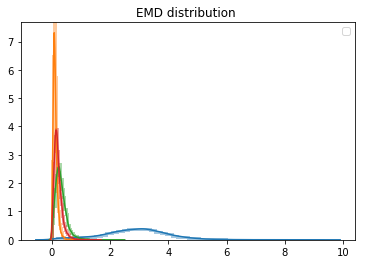

In [128]:
sns.distplot(d1, hist_kws={"histtype": "step", "linewidth": 3})
sns.distplot(d2, hist_kws={"histtype": "step", "linewidth": 3})
sns.distplot(d3, hist_kws={"histtype": "step", "linewidth": 3})
sns.distplot(d4, hist_kws={"histtype": "step", "linewidth": 3})

plt.title('EMD distribution ')


plt.legend()